In [0]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Sklearn linear regression model
from sklearn.linear_model import LinearRegression

# Sklearn regression model evaluation functions
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

In [2]:
#load the data and inspect the first 5 rows
dataset = pd.read_csv("bike.csv")
dataset.head()

,id,season,year,holiday,weekday,workingday,weather,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual,registered,cnt
0,12765,winter,2016,0,6,0,cloud,0.344167,0.363625,0.805833,0.160446,7,1,2,2,226,654,880
1,12766,winter,2016,0,0,0,cloud,0.363478,0.353739,0.696087,0.248539,8,1,8,1,125,670,795
2,12767,winter,2016,0,1,1,fair,0.196364,0.189405,0.437273,0.248309,3,1,10,2,75,1229,1304
3,12768,winter,2016,0,2,1,fair,0.200000,0.212122,0.590435,0.160296,0,1,8,3,67,1454,1521
4,12769,winter,2016,0,3,1,fair,0.226957,0.229270,0.436957,0.186900,2,0,5,1,58,1518,1576


In [3]:
# Confirm the data types
dataset.dtypes

id                            int64
season                       object
year                          int64
holiday                       int64
weekday                       int64
workingday                    int64
weather                      object
temp                        float64
feel_temp                   float64
hum                         float64
windspeed                   float64
promotion_level               int64
promotion_type                int64
promotion_level_external      int64
promotion_type_external       int64
casual                        int64
registered                    int64
cnt                           int64
dtype: object

In [4]:
# Check for nulls
dataset.isnull().mean()

id                          0.0
season                      0.0
year                        0.0
holiday                     0.0
weekday                     0.0
workingday                  0.0
weather                     0.0
temp                        0.0
feel_temp                   0.0
hum                         0.0
windspeed                   0.0
promotion_level             0.0
promotion_type              0.0
promotion_level_external    0.0
promotion_type_external     0.0
casual                      0.0
registered                  0.0
cnt                         0.0
dtype: float64

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:80: UserWarning: Attempting to set identical left == right == 2016.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[j])
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:81: UserWarning: Attempting to set identical bottom == top == 2016.0 results in singular transformations; automatically expanding.
  ax.set_ylim(boundaries_list[i])
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/misc.py:71: UserWarning: Attempting to set identical left == right == 2016.0 results in singular transformations; automatically expanding.
  ax.set_xlim(boundaries_list[i])


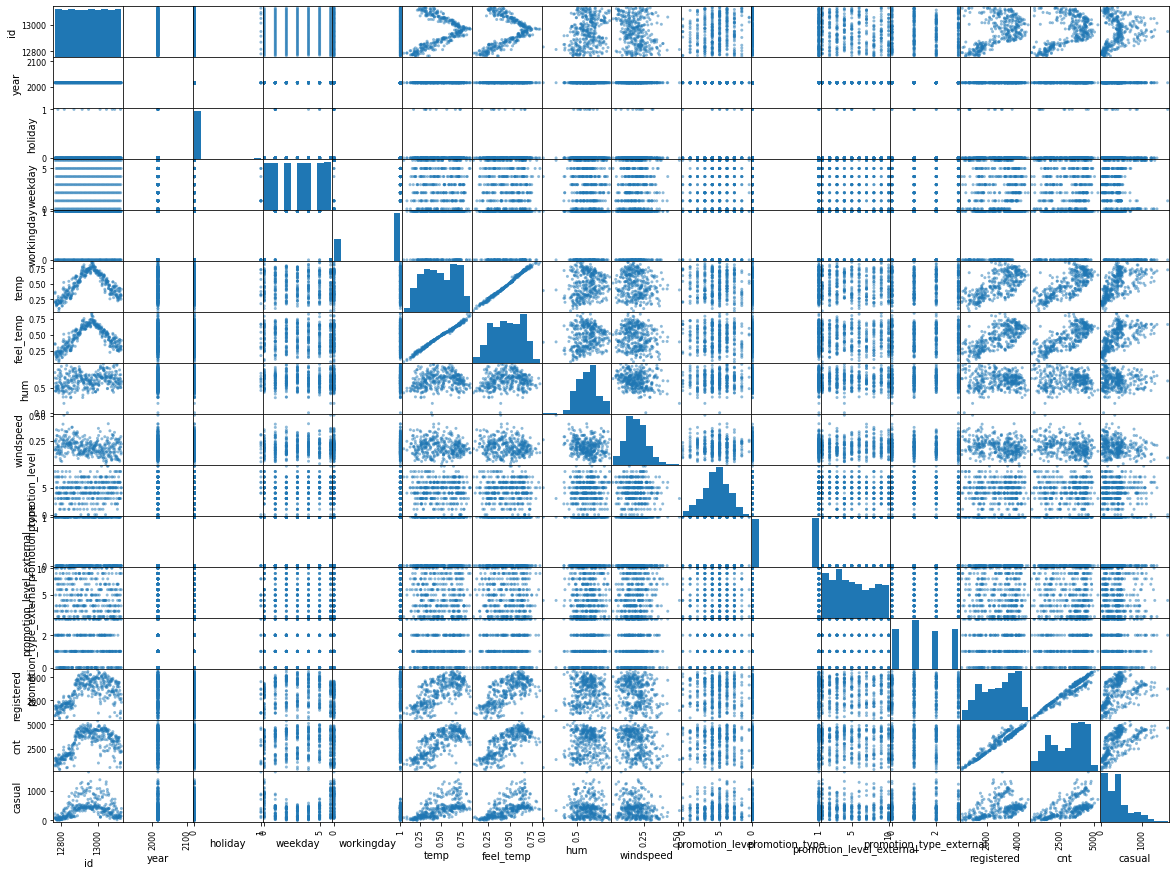

In [5]:
# Plot a scatter matrix
# I like to push the target feature to the bottom, so it is easy to read
df = dataset.drop('casual',axis=1).join(dataset.casual)
pd.plotting.scatter_matrix(df,figsize=(20,15))
plt.show()

 The two temperature columns, temp and feel_temp are unsurprisingly highly correlated. 
 We will probably want to remove one. 
 This is called Multicolinearity
 Also cnt and registered seem to be correlated.
 This is odd, as cnt is the total of casual + registered. 
 In fact, we should remove BOTH cnt and registered as they will cause "data leakage".


#FEATURE ENGINEERING

In [6]:
# Drop cnt and registered as they will cause data leakage
dataset = dataset.drop(['cnt','registered'], axis=1)

dataset = dataset.drop(['id'], axis=1)
dataset.head()

,season,year,holiday,weekday,workingday,weather,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual
0,winter,2016,0,6,0,cloud,0.344167,0.363625,0.805833,0.160446,7,1,2,2,226
1,winter,2016,0,0,0,cloud,0.363478,0.353739,0.696087,0.248539,8,1,8,1,125
2,winter,2016,0,1,1,fair,0.196364,0.189405,0.437273,0.248309,3,1,10,2,75
3,winter,2016,0,2,1,fair,0.200000,0.212122,0.590435,0.160296,0,1,8,3,67
4,winter,2016,0,3,1,fair,0.226957,0.229270,0.436957,0.186900,2,0,5,1,58


In [7]:
dataset.shape

(365, 15)

In [8]:
# We have a few categorical columns, so we should one-hot-encode these to convert them to numerical columns.

categoricals = ['season','weekday','weather']
dataset = pd.get_dummies(dataset, columns=categoricals, drop_first=True)
dataset.head()

# Notice the column "season" has been broken into three columns "season_spring", "season_summer", "season_winter"
# and is one-hot encoded.

,year,holiday,workingday,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,casual,season_spring,season_summer,season_winter,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_fair,weather_rain
0,2016,0,0,0.344167,0.363625,0.805833,0.160446,7,1,2,2,226,0,0,1,0,0,0,0,0,1,0,0
1,2016,0,0,0.363478,0.353739,0.696087,0.248539,8,1,8,1,125,0,0,1,0,0,0,0,0,0,0,0
2,2016,0,1,0.196364,0.189405,0.437273,0.248309,3,1,10,2,75,0,0,1,1,0,0,0,0,0,1,0
3,2016,0,1,0.200000,0.212122,0.590435,0.160296,0,1,8,3,67,0,0,1,0,1,0,0,0,0,1,0
4,2016,0,1,0.226957,0.229270,0.436957,0.186900,2,0,5,1,58,0,0,1,0,0,1,0,0,0,1,0


In [9]:
dataset.shape

(365, 23)

Notice the increase in the column features.

In [0]:
# Splitting into X and y

# Our target feature
y = dataset["casual"]  # df['casual'] and df.casual means the same.

# Our input features
X = dataset.drop(['casual'], axis=1) # axis = 1 specifies the drop along column dimension

In [0]:
# we can observe that our data is spread across wide differences of scale values.
# Rescale the input features
scaler = MinMaxScaler(feature_range=(0,1)) # all the features will now be in the range of [0, 1]
X_ = scaler.fit_transform(X)
X = pd.DataFrame(X_, columns=X.columns)

Notice the values, all the values are now between 0 and 1.

In [12]:
X.head()

,year,holiday,workingday,temp,feel_temp,hum,windspeed,promotion_level,promotion_type,promotion_level_external,promotion_type_external,season_spring,season_summer,season_winter,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weather_fair,weather_rain
0,0.0,0.0,0.0,0.360789,0.373517,0.828620,0.284606,0.777778,1.0,0.111111,0.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.385232,0.360541,0.715771,0.466215,0.888889,1.0,0.777778,0.333333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.173705,0.144830,0.449638,0.465740,0.333333,1.0,1.000000,0.666667,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.178308,0.174649,0.607131,0.284297,0.000000,1.0,0.777778,1.000000,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.212429,0.197158,0.449313,0.339143,0.222222,0.0,0.444444,0.333333,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Simple Linear regression.

In [0]:
# split the data into (2/3) train and (1/3) test sets.
test_size = 0.33
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)

Carefully observe the dataset shapes and the splitting ratio

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(244, 22)
(121, 22)
(244,)
(121,)


In [0]:
#custom functions
def score(model, X, y):
    """Get the model prediction scores using the provided input and target features"""
    
    predictions = model.predict(X)
    print("    R2", r2_score(y, predictions)) 

    
def linearRegressionSummary(model, column_names):
    '''Show a summary of the trained linear regression model'''

    # Plot the coeffients as bars
    fig = plt.figure(figsize=(8,len(column_names)/3))
    fig.suptitle('Linear Regression Coefficients', fontsize=16)
    rects = plt.barh(column_names, model.coef_,color="lightblue")

    # Annotate the bars with the coefficient values
    for rect in rects:
        width = round(rect.get_width(),4)
        plt.gca().annotate('  {}  '.format(width),
                    xy=(0, rect.get_y()),
                    xytext=(0,2),  
                    textcoords="offset points",  
                    ha='left' if width<0 else 'right', va='bottom')        
    plt.show()
    


In [20]:
#build our model

model = LinearRegression()

#fit the model on the training data.
model.fit(X_train, y_train)
print("On training set : ") #score is our custom function for better visualization.
score(model, X_train, y_train)

On training set : 
    R2 0.798265855369959


In [22]:
#evaluate the model on the test set
print("On testing set")
score(model, X_test, y_test)


On testing set
    R2 0.7444590452036941


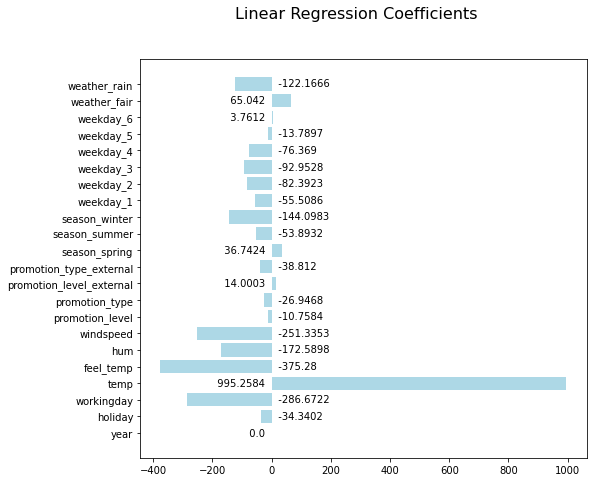

In [23]:
#summary 
linearRegressionSummary(model, X_train.columns) #this is also a custom function